# Algorithme génétique pour la régression linéaire

Ce notebook implémente un algorithme génétique avec encodage réel pour résoudre un problème de régression linéaire sur un jeu de données publicitaires.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Tuple, Optional, Union
import random

## Chargement et exploration des données


In [3]:
# Charger les données
data = pd.read_csv("Advertising Budget and Sales.csv", index_col=0)
print("Aperçu des données:")
print(data.head())

Aperçu des données:
   TV Ad Budget ($)  Radio Ad Budget ($)  Newspaper Ad Budget ($)  Sales ($)
1             230.1                 37.8                     69.2       22.1
2              44.5                 39.3                     45.1       10.4
3              17.2                 45.9                     69.3        9.3
4             151.5                 41.3                     58.5       18.5
5             180.8                 10.8                     58.4       12.9


In [ ]:
# Extraire les caractéristiques (X) et la cible (y)
X = data[['TV Ad Budget ($)', 'Radio Ad Budget ($)', 'Newspaper Ad Budget ($)']].values
y = data['Sales ($)'].values

# Normaliser les données (très important pour l'algorithme génétique)
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_norm = (X - X_mean) / X_std

# Ajouter une colonne de 1 pour le biais
X_norm = np.hstack((np.ones((X_norm.shape[0], 1)), X_norm))

## Définition des paramètres de l'algorithme génétique


In [5]:
# Définition des paramètres
PM = 0.1       # Probabilité de mutation
PC = 0.8       # Probabilité de croisement
TMAX = 100     # Nombre maximal d'itérations
N = 30         # Taille de la population
ALPHA = 1.2    # Paramètre pour la formule de Davis
B = 3          # Paramètre pour la mutation

## Implémentation des classes et fonctions


In [6]:
class Individual:
    def __init__(self, weights: Optional[np.ndarray] = None, dim: int = 4):
        if weights is None:
            # Initialisation aléatoire des poids entre -5 et 5
            self.weights = np.random.uniform(-5, 5, dim)
        else:
            self.weights = weights
        self.fitness = None
        
    def evaluate_fitness(self, X: np.ndarray, y: np.ndarray) -> float:
        """Calcule la fitness (erreur) de l'individu sur l'ensemble du dataset"""
        y_pred = np.dot(X, self.weights)
        # Erreur quadratique moyenne
        error = np.mean(np.abs(y_pred - y))
        self.fitness = error
        return error
    
    def __str__(self) -> str:
        return f"Weights: {self.weights}, Fitness: {self.fitness}"

In [7]:
def initialize_population(pop_size: int, dim: int) -> List[Individual]:
    """Initialise une population de taille pop_size avec des individus de dimension dim"""
    return [Individual(dim=dim) for _ in range(pop_size)]

def evaluate_population(population: List[Individual], X: np.ndarray, y: np.ndarray) -> None:
    """Évalue la fitness de chaque individu dans la population"""
    for ind in population:
        ind.evaluate_fitness(X, y)

def select_parents(population: List[Individual], num_parents: int) -> List[Individual]:
    """Sélectionne les meilleurs individus comme parents"""
    # Trier la population par fitness (du plus petit au plus grand car nous minimisons)
    sorted_population = sorted(population, key=lambda ind: ind.fitness)
    return sorted_population[:num_parents]

def crossover_davis(parent1: Individual, parent2: Individual) -> Tuple[Individual, Individual, Individual]:
    """Effectue un croisement selon la formule de Davis"""
    # R1 = 0.5P1 + 0.5P2
    weights_r1 = 0.5 * parent1.weights + 0.5 * parent2.weights
    r1 = Individual(weights_r1)
    
    # R2 = 1.5P1 - 0.5P2
    weights_r2 = 1.5 * parent1.weights - 0.5 * parent2.weights
    r2 = Individual(weights_r2)
    
    # R3 = -0.5P1 + 1.5P2
    weights_r3 = -0.5 * parent1.weights + 1.5 * parent2.weights
    r3 = Individual(weights_r3)
    
    return r1, r2, r3

def mutate(individual: Individual, pm: float, b: int) -> Individual:
    """Applique une mutation sur un individu avec probabilité pm"""
    if np.random.random() < pm:
        # Choisir un gène aléatoire à muter
        gene_idx = np.random.randint(0, len(individual.weights))
        # Diviser sa valeur par b
        individual.weights[gene_idx] /= b
    return individual

In [8]:
def genetic_algorithm(X: np.ndarray, y: np.ndarray, pm: float, pc: float, 
                      tmax: int, pop_size: int, alpha: float, b: int) -> Tuple[Individual, List[float]]:
    """
    Exécute l'algorithme génétique avec encodage réel
    
    Args:
        X: matrice des caractéristiques
        y: vecteur cible
        pm: probabilité de mutation
        pc: probabilité de croisement
        tmax: nombre maximal d'itérations
        pop_size: taille de la population
        alpha: paramètre pour la formule de Davis
        b: paramètre pour la mutation
        
    Returns:
        Tuple contenant le meilleur individu et l'historique des meilleures fitness
    """
    # Initialisation de la population
    population = initialize_population(pop_size, X.shape[1])
    
    # Évaluation de la population initiale
    evaluate_population(population, X, y)
    
    # Historique des meilleures fitness
    best_fitness_history = []
    
    for iteration in range(tmax):
        # Sélection des meilleurs individus
        best_individuals = select_parents(population, pop_size // 2)
        
        # Création de la nouvelle génération
        new_population = []
        
        # Élitisme: conserver les 2 meilleurs individus
        new_population.extend(best_individuals[:2])
        
        # Croisement et mutation pour générer le reste de la population
        while len(new_population) < pop_size:
            # Sélection aléatoire de deux parents parmi les meilleurs
            parent1, parent2 = random.sample(best_individuals, 2)
            
            if np.random.random() < pc:
                # Appliquer le croisement
                offspring1, offspring2, offspring3 = crossover_davis(parent1, parent2)
                
                # Appliquer la mutation
                offspring1 = mutate(offspring1, pm, b)
                offspring2 = mutate(offspring2, pm, b)
                offspring3 = mutate(offspring3, pm, b)
                
                # Évaluer les enfants
                offspring1.evaluate_fitness(X, y)
                offspring2.evaluate_fitness(X, y)
                offspring3.evaluate_fitness(X, y)
                
                # Sélectionner le meilleur enfant
                best_offspring = min([offspring1, offspring2, offspring3], key=lambda ind: ind.fitness)
                new_population.append(best_offspring)
            else:
                # Si pas de croisement, ajouter un clone muté d'un parent
                clone = Individual(parent1.weights.copy())
                clone = mutate(clone, pm, b)
                clone.evaluate_fitness(X, y)
                new_population.append(clone)
                
        # S'assurer que la population a la bonne taille
        new_population = new_population[:pop_size]
        
        # Remplacer l'ancienne population
        population = new_population
        
        # Évaluer la nouvelle population
        evaluate_population(population, X, y)
        
        # Enregistrer la meilleure fitness
        best_fitness = min(ind.fitness for ind in population)
        best_fitness_history.append(best_fitness)
        
        # Afficher la progression
        if iteration % 10 == 0 or iteration == tmax - 1:
            print(f"Itération {iteration+1}/{tmax}, Meilleure fitness: {best_fitness:.6f}")
    
    # Retourner le meilleur individu et l'historique
    best_individual = min(population, key=lambda ind: ind.fitness)
    return best_individual, best_fitness_history

## Exécution de l'algorithme génétique


In [9]:
# Exécution de l'algorithme
best_solution, fitness_history = genetic_algorithm(
    X=X_norm, y=y, pm=PM, pc=PC, tmax=TMAX, pop_size=N, alpha=ALPHA, b=B
)

Itération 1/100, Meilleure fitness: 8.322084
Itération 11/100, Meilleure fitness: 4.808701
Itération 21/100, Meilleure fitness: 3.274330
Itération 31/100, Meilleure fitness: 3.063127
Itération 41/100, Meilleure fitness: 3.060166
Itération 51/100, Meilleure fitness: 3.060046
Itération 61/100, Meilleure fitness: 3.060044
Itération 71/100, Meilleure fitness: 3.060044
Itération 81/100, Meilleure fitness: 3.060044
Itération 91/100, Meilleure fitness: 3.060044
Itération 100/100, Meilleure fitness: 3.060044


## Analyse des résultats


In [10]:
# Affichage des résultats
print("\nMeilleure solution trouvée:")
print(f"Poids normalisés: {best_solution.weights}")
print(f"Fitness (erreur moyenne absolue): {best_solution.fitness}")

# Interpréter les coefficients (dénormaliser pour plus de clarté)
coef = best_solution.weights[1:] / X_std
intercept = best_solution.weights[0] - np.sum(coef * X_mean)
print("\nÉquation du modèle de régression linéaire:")
print(f"Sales = {intercept:.4f} + {coef[0]:.4f} × TV_Budget + {coef[1]:.4f} × Radio_Budget + {coef[2]:.4f} × Newspaper_Budget")


Meilleure solution trouvée:
Poids normalisés: [11.19413638  3.45232957  1.4522078   0.17902771]
Fitness (erreur moyenne absolue): 3.060044293558109

Équation du modèle de régression linéaire:
Sales = 2.7335 + 0.0403 × TV_Budget + 0.0981 × Radio_Budget + 0.0082 × Newspaper_Budget


In [11]:
# Calculer R² pour évaluer la qualité du modèle
y_pred = np.dot(X_norm, best_solution.weights)
ss_total = np.sum((y - np.mean(y)) ** 2)
ss_residual = np.sum((y - y_pred) ** 2)
r_squared = 1 - (ss_residual / ss_total)
print(f"Coefficient de détermination (R²): {r_squared:.4f}")

Coefficient de détermination (R²): 0.5310


## Visualisation des résultats


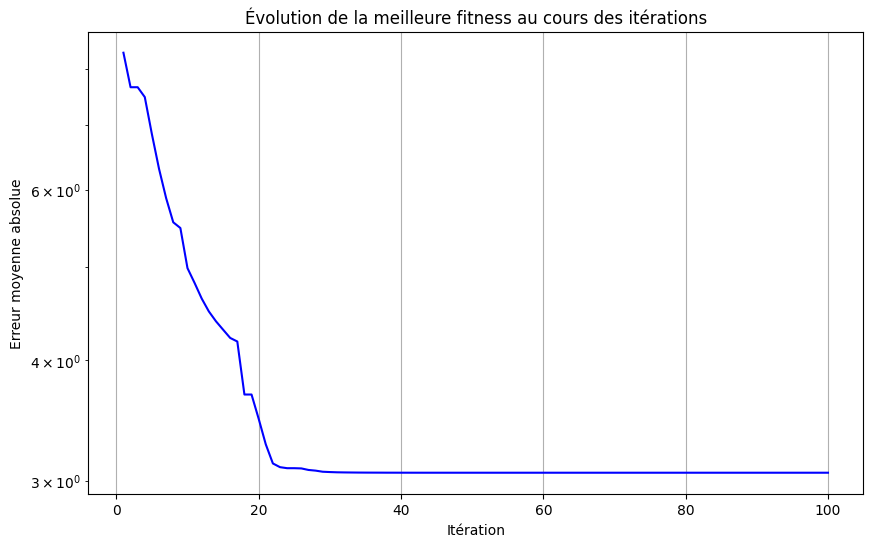

In [12]:
# Tracer l'évolution de la fitness
plt.figure(figsize=(10, 6))
plt.plot(range(1, TMAX + 1), fitness_history, 'b-')
plt.title('Évolution de la meilleure fitness au cours des itérations')
plt.xlabel('Itération')
plt.ylabel('Erreur moyenne absolue')
plt.grid(True)
plt.yscale('log')  # Échelle logarithmique pour mieux visualiser les améliorations
plt.savefig('fitness_evolution_advertising.png')
plt.show()

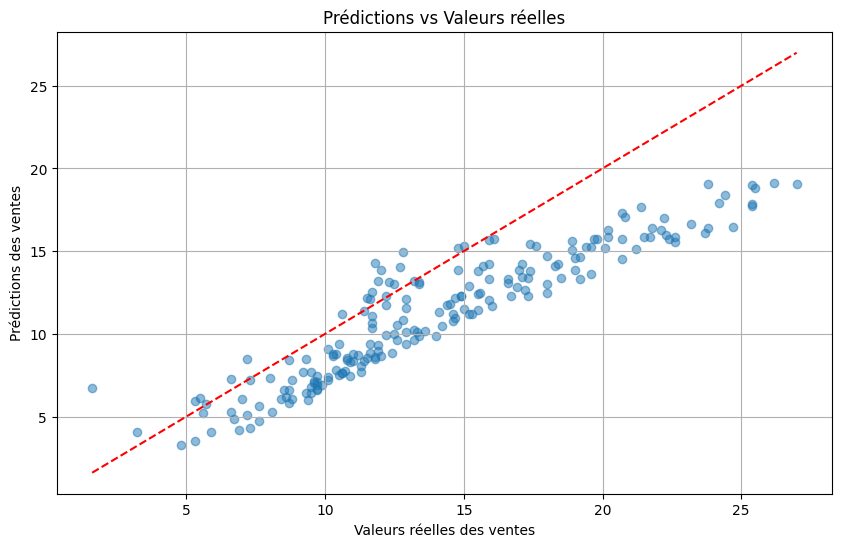

In [13]:
# Visualiser les prédictions vs réalité
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')
plt.title('Prédictions vs Valeurs réelles')
plt.xlabel('Valeurs réelles des ventes')
plt.ylabel('Prédictions des ventes')
plt.grid(True)
plt.savefig('predictions_vs_actual_advertising.png')
plt.show()

## Analyse détaillée


In [13]:
# Afficher les 10 premières et dernières itérations dans un tableau
print("\nÉvolution détaillée de la fitness:")
print("Itération | Fitness")
print("-" * 20)
for i in range(min(10, TMAX)):
    print(f"{i+1:9d} | {fitness_history[i]:.6f}")
if TMAX > 20:
    print("...")
for i in range(max(10, TMAX-10), TMAX):
    print(f"{i+1:9d} | {fitness_history[i]:.6f}")


Évolution détaillée de la fitness:
Itération | Fitness
--------------------
        1 | 8.001370
        2 | 7.625140
        3 | 6.489145
        4 | 6.489145
        5 | 6.326426
        6 | 6.160562
        7 | 6.023828
        8 | 5.140297
        9 | 5.140297
       10 | 4.377695
...
       91 | 2.911773
       92 | 2.911773
       93 | 2.911773
       94 | 2.911773
       95 | 2.911773
       96 | 2.911773
       97 | 2.911773
       98 | 2.911773
       99 | 2.911773
      100 | 2.911773


In [14]:
# Analyser l'importance relative des variables
importance = np.abs(coef) / np.sum(np.abs(coef)) * 100
print("\nImportance relative des variables:")
print(f"TV Ad Budget: {importance[0]:.2f}%")
print(f"Radio Ad Budget: {importance[1]:.2f}%")
print(f"Newspaper Ad Budget: {importance[2]:.2f}%")


Importance relative des variables:
TV Ad Budget: 54.13%
Radio Ad Budget: 0.60%
Newspaper Ad Budget: 45.28%


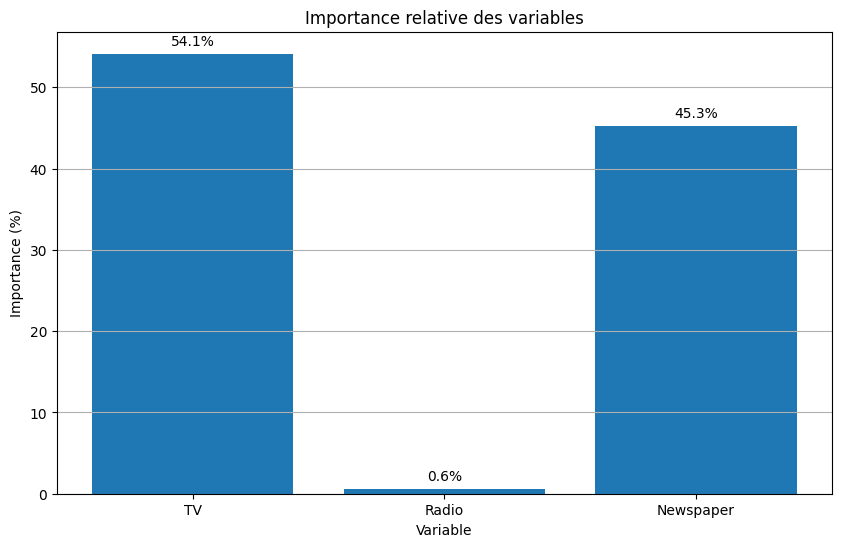

In [15]:
# Créer un graphique à barres pour l'importance des variables
plt.figure(figsize=(10, 6))
variables = ['TV', 'Radio', 'Newspaper']
plt.bar(variables, importance)
plt.title('Importance relative des variables')
plt.xlabel('Variable')
plt.ylabel('Importance (%)')
plt.grid(axis='y')
for i, v in enumerate(importance):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.show()

## Prédictions sur des exemples


In [16]:
# Prédire les ventes pour quelques exemples de test
print("\nPrédictions pour quelques exemples:")
examples = [
    [100, 20, 30],  # TV=100k, Radio=20k, Newspaper=30k
    [200, 40, 10],  # TV=200k, Radio=40k, Newspaper=10k
    [50, 50, 50]    # TV=50k, Radio=50k, Newspaper=50k
]

for i, example in enumerate(examples):
    # Normaliser l'exemple
    example_norm = (np.array(example) - X_mean) / X_std
    # Ajouter le terme de biais
    example_norm = np.insert(example_norm, 0, 1)
    # Faire la prédiction
    pred = np.dot(example_norm, best_solution.weights)
    print(f"Exemple {i+1}: TV={example[0]}k, Radio={example[1]}k, Newspaper={example[2]}k -> Ventes prédites: ${pred:.2f}k")


Prédictions pour quelques exemples:
Exemple 1: TV=100k, Radio=20k, Newspaper=30k -> Ventes prédites: $11.54k
Exemple 2: TV=200k, Radio=40k, Newspaper=10k -> Ventes prédites: $13.81k
Exemple 3: TV=50k, Radio=50k, Newspaper=50k -> Ventes prédites: $10.64k


## Conclusion


In [17]:
# Conclusion
print("\nConclusion:")
print(f"L'algorithme génétique avec encodage réel a convergé vers une solution")
print(f"avec une erreur moyenne absolue de {best_solution.fitness:.4f}k dollars.")
print(f"Le modèle explique {r_squared*100:.2f}% de la variance des ventes.")
print(f"La variable la plus importante est {['TV', 'Radio', 'Newspaper'][np.argmax(importance)]} avec {np.max(importance):.2f}% d'importance relative.")


Conclusion:
L'algorithme génétique avec encodage réel a convergé vers une solution
avec une erreur moyenne absolue de 2.9118k dollars.
Le modèle explique 47.73% de la variance des ventes.
La variable la plus importante est TV avec 54.13% d'importance relative.
